# Carbon System Example Code

**Author: Andrew Reed**

### Purpose
The purpose of this notebook is to provide an example of working with ```PHSEN``` data from the Ocean Observatories Initiative. Example datasets are provided in the ```data``` directory. This code is meant to highlight necessary post-download processing steps to improve data quality and useability.

### Data
This notebook makes use of the PHSEN dataset from the Global Irminger Array Flanking Mooring A (GI03FLMA). This instrument is located at a latitude, longitude of 59.77095, -39.88360 in the Irminger Sea, approximately XXX miles southeast of Greenland.

The example ```PHSEN``` datasets were downloaded as netCDF files from the Ocean Observatories Initiative data portal for all available, reformatted to clean up the dimensions, and then merged into one dataset. This process is outlined in the notebook **OOI - Data Downloading and Cleaning**. 

The discrete bottle data were downloaded from the OOI Alfresco Document Server at https://alfresco.oceanobservatories.org. The relevant files are in OOI > Global Irminger Sea Array > Cruise Data > "Cruise Directory" > Ship Data > Water Sampling > "Discrete Summary Sample Sheet.xlsx". For more information and an example of working with and validating discrete sample data please follow the **OOI - Discrete Bottle Data** example notebook. 

### Dependencies & Use
This notebook and related examples are all done using the Python programming language. Additionally, it relies on several github repositories and existing code bases for working with OOI data. The first is the OOINet repository at https://github.com/reedan88/OOINet. This repo hosts modules and tools that are designed to assist in requesting, importing, and downloading data from the Ocean Observatories Initiative API by M2M requests. It also utilizes code from the OOI Data Explorations repo at https://github.com/oceanobservatories/ooi-data-explorations. This repository contains modules, tools, and notebooks that also assist with downloading data from the OOI API, as well as extensive tools for processing the downloaded datasets to make them more user-friendly. Lastly, functions written specifically for this example notebook are stored in the utils.py module in the parent directory, allowing for direct imports.

In [1]:
# Import libraries
import os, shutil, sys, time, re, requests, csv, datetime, pytz
import time
import yaml
import pandas as pd
import numpy as np
import netCDF4 as nc
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import the OOINet M2M tool
sys.path.append("/home/andrew/Documents/OOI-CGSN/ooinet/ooinet/")
from m2m import M2M

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

#### Set OOINet API access
In order access and download data from OOINet, need to have an OOINet api username and access token. Those can be found on your profile after logging in to OOINet. Your username and access token should NOT be stored in this notebook/python script (for security). It should be stored in a yaml file, kept in the same directory, named user_info.yaml.

In [4]:
userinfo = yaml.load(open("../user_info.yaml"), Loader=yaml.SafeLoader)
username = userinfo["apiname"]
token = userinfo["apikey"]

#### Connect to OOINet

In [5]:
OOINet = M2M(username, token)

---
## Load the data

In [6]:
# Load the phsen dataset from the local directory
phsen = xr.open_dataset("../data/GI03FLMA-RIS01-04-PHSENF000_combined.nc", chunks="auto")

# For convience, also set the reference designator name
refdes = "GI03FLMA-RIS01-04-PHSENF000"

Look at the structure of the ```PHSEN``` dataset:

In [7]:
phsen

<xarray.Dataset>
Dimensions:                            (time: 30468, blanks: 4, measurements: 23, phsen_abcdef_signal_intensity_434_dim_0: 23, phsen_abcdef_signal_intensity_578_dim_0: 23)
Coordinates:
  * blanks                             (blanks) int32 0 1 2 3
  * measurements                       (measurements) int32 0 1 2 3 ... 20 21 22
  * time                               (time) datetime64[ns] 2014-09-13 ... 2...
Dimensions without coordinates: phsen_abcdef_signal_intensity_434_dim_0, phsen_abcdef_signal_intensity_578_dim_0
Data variables: (12/23)
    blank_refrnc_434                   (time, blanks) float64 dask.array<chunksize=(30468, 4), meta=np.ndarray>
    blank_refrnc_578                   (time, blanks) float64 dask.array<chunksize=(30468, 4), meta=np.ndarray>
    blank_signal_434                   (time, blanks) float64 dask.array<chunksize=(30468, 4), meta=np.ndarray>
    blank_signal_578                   (time, blanks) float64 dask.array<chunksize=(30468, 4), meta=np.ndarray>
    deployment                         (time) float64 dask.array<chunksize=(30468,), meta=np.ndarray>
    passed_checksum                    (time) float32 dask.array<chunksize=(30468,), meta=np.ndarray>
    ...                                 ...
    seawater_ph_quality_flag           (time) float64 dask.array<chunksize=(30468,), meta=np.ndarray>
    signal_434                         (time, measurements) float64 dask.array<chunksize=(30468, 23), meta=np.ndarray>
    signal_578                         (time, measurements) float64 dask.array<chunksize=(30468, 23), meta=np.ndarray>
    sio_controller_timestamp           (time) datetime64[ns] dask.array<chunksize=(30468,), meta=np.ndarray>
    thermistor_temperature             (time) float64 dask.array<chunksize=(30468,), meta=np.ndarray>
    unique_id                          (time) float32 dask.array<chunksize=(30468,), meta=np.ndarray>
Attributes: (12/70)
    node:                               RIS01
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_inst
    stream:                             phsen_abcdef_instrument
    ...                                 ...
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                59.76683
    lon:                                -39.8425
    Location_name:                      Global Irminger Sea Flanking Subsurfa...

The principle data variable we are interested in is the ```seawater_ph``` variable. Other data variables we will be using are the ```deployment``` variable, which contains an entry for which deployment each timestamp corresponds to.

Now, plot the ```seawater_ph``` data variable along with the relevant deployments to get an idea of when the instrument was changed.

In [303]:
def plot_variable(ds, param, add_deployments=True):
    """Function to plot the timeseries with deployment info.

    Parameters
    ----------
    ds: (xarray.Dataset)
        An xarray dataset downloaded from OOINet
    param: (str)
        The parameter name of the data variable in the OOI
        dataset to plot
    add_deployments: (boolean)
        Also plot deployment information

    Returns
    -------
    fig, ax: (matplotlib figs)
        Figure and axis handles for the matplotlib image
    """
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Calculate the figure bounds
    yavg, ystd = ds[param].mean(), ds[param].std()
    ymin = yavg - 5*ystd
    ymax = yavg + 5*ystd
    
    # Generate the plot figure
    if add_deployments:
        s = ds.plot.scatter("time", param, ax=ax, hue="deployment", hue_style="discrete")
    else:
        s = ds.plot.scatter("time", param, ax=ax)
        
    # Add in limits and labels
    ax.set_ylim((ymin, ymax))
    xlabel = ax.get_xlabel()
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ds[param].attrs["long_name"], fontsize=14)
    ax.set_title(ds.attrs["id"], fontsize=16)
    ax.grid()
    
    # Add in legend if deployments added
    if add_deployments:
        ax.legend(edgecolor="black", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12, title="Deployments")
        deployments = np.unique(phsen["deployment"])
        for depNum in deployments:
            dt = phsen.where(phsen["deployment"] == depNum, drop=True)["time"].min()
            ax.vlines(dt.values, yavg-5*ystd, yavg+5*ystd)
            ax.text(dt.values, yavg-4*ystd, str(int(depNum)), fontsize=14)
            
    fig.autofmt_xdate()
    
    return fig, ax

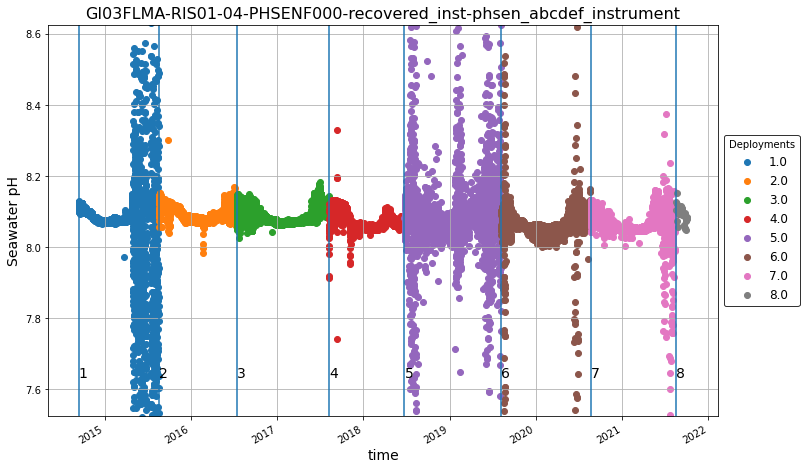

In [304]:
fig, ax = plot_variable(phsen, "seawater_ph")

We see from this figure that there have been eight deployments of a ```PHSEN``` instrument at GI03FLMA-RIS01-04-PHSENF000. We can also see that there are differences in variability both within deployments, such as deployment 1, and between deployments, such as the contrasting variability of deployment 4 vs. deployment 5.

The next step is to take a look at the annotations and see what they indicate about the data.

---
## Annotations

Since we are loading annotations which were previously downloaded and saved as a csv, we first need to do some parsing of the annotations to properly work with lists, etc. in the pandas dataframe.

In [305]:
from ast import literal_eval

In [16]:
downloaded_annotations = pd.read_csv("../data/GI03FLMA-RIS01-04-PHSENF000_annotations.csv")
downloaded_annotations["stream"] = downloaded_annotations["stream"].astype(object)
downloaded_annotations = downloaded_annotations.where(downloaded_annotations.notnull(), None)
downloaded_annotations["parameters"] = downloaded_annotations["parameters"].apply(lambda x: literal_eval(x))
downloaded_annotations.drop(columns=["Unnamed: 0"], inplace=True)
downloaded_annotations

,@class,id,subsite,node,sensor,method,stream,beginDT,endDT,annotation,exclusionFlag,source,qcFlag,parameters
0,.AnnotationRecord,683,GI03FLMA,None,None,None,None,1410552660000,1.439894e+12,Deployment 1: Mooring was deployed 10-15m shal...,False,lgarzio@marine.rutgers.edu,0,[]
1,.AnnotationRecord,684,GI03FLMA,None,None,None,None,1439941680000,1.468714e+12,Deployment 2: Mooring was deployed 5-10m deepe...,False,lgarzio@marine.rutgers.edu,0,[]
2,.AnnotationRecord,1427,GI03FLMA,RIS01,None,telemetered,None,1528639140000,1.565555e+12,Deployment 5: The secondary controller did not...,False,cdobson@whoi.edu,0,[]
3,.AnnotationRecord,1450,GI03FLMA,None,None,None,None,1502207940000,1.529050e+12,Deployment 4: Mooring was deployed 5-10m deepe...,False,lgarzio@marine.rutgers.edu,0,[]
4,.AnnotationRecord,2395,GI03FLMA,RIS01,04-PHSENF000,recovered_host,None,1565184840000,1.598526e+12,Deployment 6: The secondary controller failed ...,False,cdobson@whoi.edu,9,[]
5,.AnnotationRecord,2419,GI03FLMA,None,None,telemetered,None,1606007460000,1.629193e+12,Deployment 7: No telemetered data expected aft...,False,cdobson@whoi.edu,9,[]
6,.AnnotationRecord,3160,GI03FLMA,RIS01,None,None,None,1530658800000,1.536931e+12,Deployment 5: Secondary controller stopped due...,False,swhite@whoi.edu,9,[]
7,.AnnotationRecord,3159,GI03FLMA,RIS01,None,None,None,1518523200000,1.528639e+12,Deployment 4: Secondary controller stopped due...,False,swhite@whoi.edu,9,[]
8,.AnnotationRecord,3162,GI03FLMA,RIS01,None,None,None,1574970300000,1.598526e+12,Deployment 6: Secondary controller stopped due...,False,swhite@whoi.edu,9,[]
9,.AnnotationRecord,689,GI03FLMA,RIS01,None,None,None,1453338000000,1.459327e+12,Deployment 2: Secondary controller stopped due...,False,swhite@whoi.edu,9,[]


Now we can look at a specific annotation. Lets see what the **```id```** 1427 says:

In [306]:
downloaded_annotations.loc[2, "annotation"]

'Deployment 5: The secondary controller did not establish communications at deployment; there will be no telemetered data from the instruments connected to this controller. The instruments should be logging internally and data should be available at recovery.'

This is a fairly self-explanatory annotation. If we were looking just for telemetered data, this would be valuable. However, since we are using a dataset which merged both instrument, host, and telemetered methods, we don't have to worry about this. 

Now, we can add the "qc_flag" from the annotations to our dataset:

In [307]:
# Add in the annotation qc flags
phsen = OOINet.add_annotation_qc_flag(phsen, downloaded_annotations)

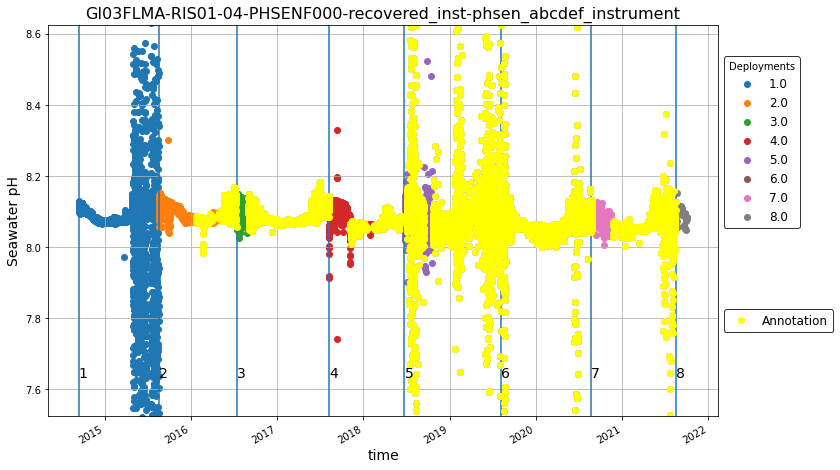

In [309]:
fig, ax = plot_variable(phsen, "seawater_ph")
ax.set_alpha(0.7)
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)

s, = ax.plot(phsen.time.where(phsen.rollup_annotations_qc_results == 9), 
             phsen.seawater_ph.where(phsen.rollup_annotations_qc_results == 9), 
             marker="o", linestyle="", color="yellow", label="Annotation")

ax.legend(handles=[s], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)


We can see that there are annotations which cover a lot of the available PHSEN data. If desired, we can take a look at each individual annotation. However, the annotations for this dataset are almost all related to communications issues and not data issues, so we can go ahead keep the highlighted data for now.

---
## Process for suspect data

This part of the workbook processes the data using code from data_explorations to remove bad datapoints. These values are based on conversations with Sunburst Instruments, LLC. and feedback from their experts. These flags should NOT be taken as truth, but as experienced guide to suspicious data.

In [19]:
sys.path.append("/home/andrew/Documents/OOI-CGSN/oceanobservatories/ooi-data-explorations/python/")

In [20]:
!pip install Munch

In [21]:
from ooi_data_explorations.cabled.process_phsen import quality_checks

#### Quality Checks

The quality checks which are run on the PHSEN data come from OOI consultations with Sunburst Sensors, LLC. The quality checks examine the instrument blanks, variability, and signal strength to determine if the measured seawater pH is suspect due to poor measurement. The flags used here correspond to standard QARTOD QC-flagging, with 1 = good, 3 = suspect, and 4 = bad.

In [22]:
phsen["seawater_ph_quality_checks"] = quality_checks(phsen)

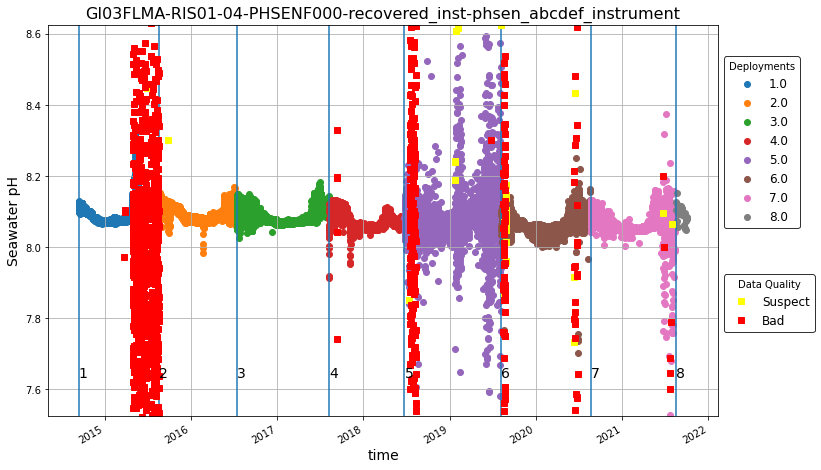

In [310]:
# Plot the data quality checks
fig, ax = plot_variable(phsen, "seawater_ph", add_deployments=True)
ax.set_alpha(0.7)
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)

f1, = ax.plot(phsen.time.where(phsen.seawater_ph_quality_checks == 3), 
             phsen.seawater_ph.where(phsen.seawater_ph_quality_checks == 3),
             marker="s", linestyle="", color="yellow", label="Suspect")

f2, = ax.plot(phsen.time.where(phsen.seawater_ph_quality_checks == 4), 
             phsen.seawater_ph.where(phsen.seawater_ph_quality_checks == 4),
             marker="s", linestyle="", color="red", label="Bad")

ax.legend(handles=[f1, f2], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12, title="Data Quality")


From the above figure, we can see that a lot of the time periods of large variability have been flagged as "bad". We can go ahead and remove the bad and suspect data from the PHSEN dataset, leaving us with the "good" PHSEN data. 

In [59]:
# Now, remove the bad data
phsen_good = phsen.where(phsen.seawater_ph_quality_flag == 1, drop=True)

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:title={'center':'GI03FLMA-RIS01-04-PHSENF000-recovered_inst-phsen_abcdef_instrument'}, xlabel='time', ylabel='Seawater pH'>)

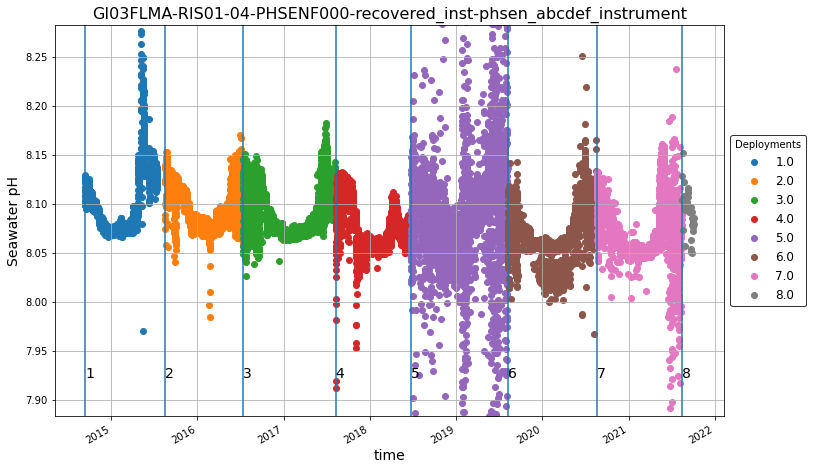

In [60]:
plot_variable(phsen_good, "seawater_ph")

---
## Bottle Data

The next step is to start comparing the PHSEN-measured seawater pH against the pH measured via Niskin collection and lab analysis. We start by loading all of the availabe Global Irminger Sea Array > Discrete Sample Summary sheets into a pandas dataframe. 

Once the bottle data is loaded, we need to do some processing to make the data easier to work with in python with pandas. The processing steps we'll take include:
1. Replacing fill values with NaNs
2. Parsing and converting timestamps
3. Replacing odd/unexpected values
4. Interpreting the quality flags to correspond to QARTOD QC standards
5. Filtering out bad data

In [312]:
bottle_dir = "../data/bottle_data/"
bottle_data = pd.DataFrame()
for file in os.listdir(bottle_dir):
    bottle_data = bottle_data.append(pd.read_excel(bottle_dir + file), ignore_index=True)

Replace the fill value of ```-9999999``` with NaNs:

In [313]:
bottle_data = bottle_data.replace(to_replace="-9999999", value=np.nan)
bottle_data = bottle_data.replace(to_replace=-9999999, value=np.nan)

Convert times from strings to pandas datetime objects and remove the timezone:

In [314]:
def convert_times(x):
    if type(x) is str:
        x = x.replace(" ","")
        x = pd.to_datetime(x, utc=False)
    else:
        pass
    return x

In [315]:
bottle_data["Start Time [UTC]"] = bottle_data["Start Time [UTC]"].apply(lambda x: convert_times(x))
bottle_data["CTD Bottle Closure Time [UTC]"] = bottle_data["CTD Bottle Closure Time [UTC]"].apply(lambda x: convert_times(x))

Convert any values with a "<", which indicates a value not statistically significant from zero, with zero:

In [316]:
def not_statistically_sigificant(x):
    if type(x) is str:
        if "<" in x:
            x = 0
    return x

In [317]:
bottle_data = bottle_data.applymap(not_statistically_sigificant)

#### Filter data
Next, we want to filter the data based on the data flag associated with the sample. First, we should drop all of the ```NaN``` values in the Niskin column to eliminate entries without any bottle samples. While these CTD casts may be of interest, the bottle data does not have the relevant data.

In [168]:
import re

class QualityFlags():
    """Primary flags for QARTOD"""
    
    GOOD = 1
    UNKNOWN = 2
    SUSPECT = 3
    BAD = 4
    MISSING = 9

FLAGS = QualityFlags

def check_fill(flag):
    """Function to check if the flag is a fill value"""
    if pd.isna(flag):
        return True
    elif str(flag) == "-9999999":
        return True
    elif "1" not in str(flag):
        return True
    else:
        return False

def parse_flag(flag):
    """Function to parse the quality flag. Returns fill or nan when appropriate."""
    locs=[]
    for match in re.finditer("1", flag[::-1], re.S):
        locs.append(match.span()[0])
    return locs
    
def interp_ctd_flag(flag):
    "Function which interprets CTD flags to standard convention"
    
    # First filter for fill 
    if check_fill(flag):
        return flag
    else:
        parsed_flag = parse_flag(flag)
        max_bit = max(parsed_flag)
        if max_bit == 1:
            return QualityFlags.MISSING
        elif max_bit == 2:
            return QualityFlags.GOOD
        elif max_bit == 3:
            return QualityFlags.SUSPECT
        elif max_bit == 4:
            return QualityFlags.BAD
        else:
            return QualityFlags.UNKNOWN
        
def interp_discrete_flag(flag):
    """Function which interprets discrete Bottle flags to standard convention."""
    
    # First filter for fill values
    if check_fill(flag):
        return flag
    else:
        parsed_flag = parse_flag(flag)
        max_bit = max(parsed_flag)
        if max_bit == 1:
            return QualityFlags.MISSING
        elif max_bit == 2:
            return QualityFlags.GOOD
        elif max_bit == 3:
            return QualityFlags.SUSPECT
        elif max_bit == 4:
            return QualityFlags.BAD
        else:
            return QualityFlags.UNKNOWN
        
def interp_replicate_flag(flag):
    """Function which returns a boolean if a sample has a duplicate/replicate sample."""
    
    # First filter for fill values
    if check_fill(flag):
        return flag
    else:
        parsed_flag = parse_flag(flag)
        max_bit = max(parsed_flag)
        if max_bit == 3 or max_bit == 4:
            return True
        else:
            return False
        
def interp_niskin_flag(flag):
    """Function which interprets Niskin bottle flags"""
    
    if check_fill(flag):
        return flag
    else:
        parsed_flag = parse_flag(flag)
        max_bit = max(parsed_flag)
        if max_bit == 1:
            return QualityFlags.MISSING
        elif max_bit == 2:
            return QualityFlags.GOOD
        elif max_bit == 3 or max_bit == 4 or max_bit == 5:
            return QualityFlags.SUSPECT
        else:
            return QualityFlags.UNKNOWN

In [169]:
# Deployment
for col in bottle_data.columns:
    if "Flag" in col:
        if "CTD" in col and "File" not in col:
            bottle_data[col] = bottle_data[col].apply(lambda x: interp_ctd_flag(x))
        elif "Discrete" in col:
            bottle_data[col] = bottle_data[col].apply(lambda x: interp_discrete_flag(x))
        elif "Replicate" in col:
            bottle_data[col] = bottle_data[col].apply(lambda x: interp_replicate_flag(x))
        elif "Niskin" in col:
            bottle_data[col] = bottle_data[col].apply(lambda x: interp_niskin_flag(x))
        else:
            pass

In [170]:
bottle_data.head()

,Cruise,Station,Target Asset,Start Latitude [degrees],Start Longitude [degrees],Start Time [UTC],Cast,Cast Flag,Bottom Depth at Start Position [m],CTD File,...,Discrete pH Replicate Flag,Calculated Alkalinity [umol/kg],Calculated DIC [umol/kg],Calculated pCO2 [uatm],Calculated pH,Calculated CO2aq [umol/kg],Calculated Bicarb [umol/kg],Calculated CO3 [umol/kg],Calculated Omega-C,Calculated Omega-A
0,AR30-03,1,Release Test,62.7715,-28.656667,2018-06-06 08:16:04+00:00,1,*0000000000000100,1858.0,D:\Data\ar30-03001.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AR30-03,1,Release Test,62.7715,-28.656667,2018-06-06 08:16:04+00:00,1,*0000000000000100,1858.0,D:\Data\ar30-03001.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AR30-03,1,Release Test,62.7715,-28.656667,2018-06-06 08:16:04+00:00,1,*0000000000000100,1858.0,D:\Data\ar30-03001.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AR30-03,1,Release Test,62.7715,-28.656667,2018-06-06 08:16:04+00:00,1,*0000000000000100,1858.0,D:\Data\ar30-03001.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AR30-03,1,Release Test,62.7715,-28.656667,2018-06-06 08:16:04+00:00,1,*0000000000000100,1858.0,D:\Data\ar30-03001.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
### Calculate Carbon System Parameters
---
The discrete water samples were tested for Total Alkalinity, Dissolved Inorganic Carbon, and pH [Total Scale]. I calculate the discrete water sample pCO<sub>2</sub> concentrations from the TA and DIC using the ```CO2SYS``` program. 

In [171]:
# Calculate the Carbon System Parameters
from PyCO2SYS import CO2SYS

---
### Calculate Physical Properties
With the bottle samples cleaned up, we next want to calculate the conservative seawater properties, such as density, conservative temperature, absolute salinity, etc., using the updated TEOS properties with the ```gsw``` package.

In [172]:
import gsw

In [173]:
# ======================================================================
# Deployment: Calculate some key physical parameters to get density based on TEOS-10
SP = bottle_data[["CTD Salinity 1 [psu]", "CTD Salinity 2 [psu]"]].mean(axis=1)
T = bottle_data[["CTD Temperature 1 [deg C]", "CTD Temperature 2 [deg C]"]].mean(axis=1)
P = bottle_data["CTD Pressure [db]"]
LAT = bottle_data["CTD Latitude [deg]"]
LON = bottle_data["CTD Longitude [deg]"]

# Absolute salinity
SA = gsw.conversions.SA_from_SP(SP, P, LON, LAT)
bottle_data["CTD Absolute Salinity [g/kg]"] = SA

# Conservative temperature
CT = gsw.conversions.CT_from_t(SA, T, P)
bottle_data["CTD Conservative Temperature"] = CT

# Density
RHO = gsw.density.rho(SA, CT, P)
bottle_data["CTD Density [kg/m^3]"] = RHO

# Calculate potential density
SIGMA0 = gsw.density.sigma0(SA, CT)
bottle_data["CTD Sigma [kg/m^3]"] = RHO

del SP, T, P, LAT, LON, SA, CT, RHO, SIGMA0

---
### Calculate Carbon System Parameters
The discrete water samples were tested for Total Alkalinity, Dissolved Inorganic Carbon, and pH [Total Scale]. We can calculate the discrete water sample pCO<sub>2</sub> concentrations from the TA and DIC using the ```CO2SYS``` program. 

Use of ```CO2SYS``` requires, at a minimum, the following inputs:
* ```PAR1```: First measured carbon system measurement
* ```PAR2```: Second measured carbon system measurement
* ```PAR1_type```: The type of PAR1 
        * 1 = Total Alkalinity umol/kg
        * 2 = DIC umol/kg
        * 3 = pH Total Scale
        * 4 = pCO2
        * 5 = fCO2
* ```PAR2_type```: The type of PAR2

The following are optional hydrographic inputs:
* ```salinity```: practical salinity
* ```temperature```: the temperature at which PAR1 and PAR2 are provided (in C)
* ```pressure```: the water pressure at which ```PAR1``` and ```PAR2``` are measured


In [207]:
PAR1 = bottle_data['Discrete Alkalinity [umol/kg]']
PAR2 = bottle_data['Discrete DIC [umol/kg]']
PAR1TYPE = 1
PAR2TYPE = 2
SAL = bottle_data['Discrete Salinity [psu]']
TEMPIN = 25
TEMPOUT = bottle_data[["CTD Temperature 1 [deg C]", "CTD Temperature 2 [deg C]"]].mean(axis=1)
PRESIN = 0
PRESOUT = bottle_data['CTD Pressure [db]']
SI = bottle_data['Discrete Silicate [uM]'].fillna(value=0)
PO4 = bottle_data['Discrete Phosphate [uM]'].fillna(value=0)
PHSCALEIN = 1
K1K2CONSTANTS = 1
K2SO4CONSTANTS = 1

In [208]:
CO2dict = CO2SYS(PAR1, PAR2, PAR1TYPE, PAR2TYPE, SAL, TEMPIN, TEMPOUT, PRESIN, PRESOUT, SI, PO4, PHSCALEIN, K1K2CONSTANTS, K2SO4CONSTANTS)

In [209]:
# Now add the calculated carbon system parameters to the cruise info
bottle_data['Calculated Alkalinity [umol/kg]'] = CO2dict['TAlk']
bottle_data['Calculated CO2aq [umol/kg]'] = CO2dict['CO2out']
bottle_data['Calculated CO3 [umol/kg]'] = CO2dict['CO3out']
bottle_data['Calculated DIC [umol/kg]'] = CO2dict['TCO2']
bottle_data['Calculated pCO2 [uatm]'] = CO2dict['pCO2out']
bottle_data['Calculated pCO2in'] = CO2dict['pCO2in']
bottle_data['Calculated pH'] = CO2dict['pHoutTOTAL']

In [210]:
bottle_data[["Discrete pH [Total scale]","Calculated pH"]].dropna()

,Discrete pH [Total scale],Calculated pH
56,7.717000,8.015876
62,7.763200,8.060732
63,7.787300,8.068241
64,7.789000,8.078555
105,7.745500,8.046546
232,7.758400,8.058061
366,7.714300,8.053597
370,7.844200,8.181017
371,7.868000,8.156065
372,7.866900,8.149366


In [211]:
import haversine as hs

def findNearest(bottleData, buoyLoc, maxDist):
    """Find the bottle sample values within a maximum distance from the buoy
    
    Parameters
    ----------
    bottleData: (pd.DataFrame -> strings or floats)
        A tuple of (latitude, longitude) values in decimal degrees of the bottle sample location
    buoyLoc: (tuple -> floats)
        A tuple of (latitude, longitude) values in decimal degrees of the buoy location
    maxDist: (float)
        Maximum distance in km away for a sample location from the buoy location
    
    Returns
    -------
    mask: (boolean)
        Returns True or False boolean if sampleLoc < maxDist from buoyLoc
    """
    # Get the startLat/startLon as floats
    startLat = bottleData["Start Latitude [degrees]"].apply(lambda x: float(x))
    startLon = bottleData["Start Longitude [degrees]"].apply(lambda x: float(x))
    
    # Calculate the distance
    distance = []
    for lat, lon in zip(startLat, startLon):
        sampleLoc = (lat, lon)
        distance.append(hs.haversine(sampleLoc, buoyLoc))
    
    # Filter the results
    return [d <= maxDist for d in distance]

In [212]:
def findSamples(bottleData, buoyLoc, buoyDepth, maxDist, depthTol):
    
    """Find the bottle sample values within a maximum distance from the buoy
    
    Parameters
    ----------
    bottleData: (pd.DataFrame -> strings or floats)
        A tuple of (latitude, longitude) values in decimal degrees of the bottle sample location
    buoyLoc: (tuple -> floats)
        A tuple of (latitude, longitude) values in decimal degrees of the buoy location
    buoyDepth: (float)
        Deployment depth of the instrument
    maxDist: (float)
        Maximum distance in km away for a sample location from the buoy location
    depthTol: (float)
        Maximum depth difference to select samples from the buoyDepth
    
    Returns
    -------
    mask: (boolean)
        Returns True or False boolean if sampleLoc < maxDist from buoyLoc
    """
    # Filter for the nearest samples
    nearest = findNearest(bottleData, buoyLoc, maxDist)
    bottleData = bottleData[nearest]
    
    # Filter based on depth
    depthMin = buoyDepth - depthTol
    depthMax = buoyDepth + depthTol
    bottleData = bottleData[(bottleData["CTD Depth [m]"] >= depthMin) & (bottleData["CTD Depth [m]"] <= depthMax)]
    
    return bottleData

In [213]:
deployments = OOINet.get_deployments(refdes)
deployments

,deploymentNumber,uid,assetId,latitude,longitude,depth,deployStart,deployEnd,deployCruise,recoverCruise
0,8,CGINS-PHSENF-P0141,3231,59.77095,-39.8836,30.0,2021-08-13 13:22:00,NaT,AR60-01,None
0,7,CGINS-PHSENF-P0104,3284,59.767117,-39.843617,30.0,2020-08-19 14:48:00,2021-08-17 09:36:00,AR46,AR60-01
0,6,CGINS-PHSENF-P0141,3231,59.7701,-39.88419,30.0,2019-08-07 13:34:00,2020-08-27 10:54:00,AR35-05,AR46
0,5,CGINS-PHSENF-P0182,3180,59.76805,-39.84252,30.0,2018-06-10 13:59:00,2019-08-11 08:25:00,AR30-03,AR35-05
0,4,CGINS-PHSENF-P0081,1271,59.7717,-39.8827,30.0,2017-08-08 15:13:00,2018-06-15 07:59:00,AR21,AR30-03
0,3,CGINS-PHSENF-P0103,3285,59.7677,-39.84123,30.0,2016-07-12 15:59:00,2017-08-12 10:00:00,AR7-01,AR21
0,2,CGINS-PHSENF-P0174,3269,59.77067,-39.8801,31.0,2015-08-18 23:47:00,2016-07-17 07:55:00,AT30-01,AR7-01
0,1,CGINS-PHSENF-P0079,1241,59.76683,-39.8425,26.0,2014-09-12 20:11:00,2015-08-18 09:00:00,KN221-04,AT30-01


In [214]:
deployment_depth = deployments["depth"].mean()

In [215]:
phsen.lat, phsen.lon, deployment_depth

(59.76683, -39.8425, 29.625)

In [216]:
bottles = findSamples(bottle_data, (phsen.lat, phsen.lon), deployment_depth, 5, 10)
bottles

,Cruise,Station,Target Asset,Start Latitude [degrees],Start Longitude [degrees],Start Time [UTC],Cast,Cast Flag,Bottom Depth at Start Position [m],CTD File,...,Calculated CO2aq [umol/kg],Calculated Bicarb [umol/kg],Calculated CO3 [umol/kg],Calculated Omega-C,Calculated Omega-A,CTD Absolute Salinity [g/kg],CTD Conservative Temperature,CTD Density [kg/m^3],CTD Sigma [kg/m^3],Calculated pCO2in
105,AR30-03,7,FLMA,59.770667,-39.859000,2018-06-10 14:37:43+00:00,7,*0000000000000100,2720.0,D:\Data\ar30-03007.hex,...,20.375968,NaN,116.394532,NaN,NaN,35.025455,5.038746,1027.701504,1027.701504,937.137881
106,AR30-03,7,FLMA,59.770667,-39.859000,2018-06-10 14:37:43+00:00,7,*0000000000000100,2720.0,D:\Data\ar30-03007.hex,...,NaN,NaN,NaN,NaN,NaN,35.025455,5.038746,1027.701504,1027.701504,NaN
107,AR30-03,7,FLMA,59.770667,-39.859000,2018-06-10 14:37:43+00:00,7,*0000000000000100,2720.0,D:\Data\ar30-03007.hex,...,NaN,NaN,NaN,NaN,NaN,35.025557,5.040039,1027.701686,1027.701686,NaN
108,AR30-03,7,FLMA,59.770667,-39.859000,2018-06-10 14:37:43+00:00,7,*0000000000000100,2720.0,D:\Data\ar30-03007.hex,...,NaN,NaN,NaN,NaN,NaN,35.027706,5.129491,1027.644028,1027.644028,NaN
109,AR30-03,7,FLMA,59.770667,-39.859000,2018-06-10 14:37:43+00:00,7,*0000000000000100,2720.0,D:\Data\ar30-03007.hex,...,NaN,NaN,NaN,NaN,NaN,35.027958,5.130790,1027.643874,1027.643874,NaN
197,AR30-03,13,Test Cast,59.780333,-39.826833,2018-06-14 20:15:22+00:00,13,*0000000000000100,NaN,D:\Data\ar30-03013.hex,...,NaN,NaN,NaN,NaN,NaN,35.022995,5.404320,1027.656100,1027.656100,NaN
397,AR7-01,8,FLMA,59.769500,-39.858667,2016-07-12 19:23:48+00:00,8,*0000000000000100,2721.0,D:\Data\ar0701008.hex,...,15.833877,NaN,148.867229,NaN,NaN,35.012560,7.496073,1027.371124,1027.371124,713.999197
398,AR7-01,8,FLMA,59.769500,-39.858667,2016-07-12 19:23:48+00:00,8,*0000000000000100,2721.0,D:\Data\ar0701008.hex,...,NaN,NaN,NaN,NaN,NaN,35.012560,7.496073,1027.371124,1027.371124,NaN
560,AT30-01,10,GI03FLMA-2,59.761833,-39.880667,2015-08-19 21:15:33+00:00,10,*0000000000000100,2690.0,C:\data\ctd\at30_010.hex,...,19.390636,NaN,123.710966,NaN,NaN,35.117941,5.340275,1027.756433,1027.756433,892.124610
561,AT30-01,10,GI03FLMA-2,59.761833,-39.880667,2015-08-19 21:15:33+00:00,10,*0000000000000100,2690.0,C:\data\ctd\at30_010.hex,...,NaN,NaN,NaN,NaN,NaN,35.117941,5.340275,1027.756433,1027.756433,NaN


In [217]:
bottles

,Cruise,Station,Target Asset,Start Latitude [degrees],Start Longitude [degrees],Start Time [UTC],Cast,Cast Flag,Bottom Depth at Start Position [m],CTD File,...,Calculated CO2aq [umol/kg],Calculated Bicarb [umol/kg],Calculated CO3 [umol/kg],Calculated Omega-C,Calculated Omega-A,CTD Absolute Salinity [g/kg],CTD Conservative Temperature,CTD Density [kg/m^3],CTD Sigma [kg/m^3],Calculated pCO2in
105,AR30-03,7,FLMA,59.770667,-39.859000,2018-06-10 14:37:43+00:00,7,*0000000000000100,2720.0,D:\Data\ar30-03007.hex,...,20.375968,NaN,116.394532,NaN,NaN,35.025455,5.038746,1027.701504,1027.701504,937.137881
106,AR30-03,7,FLMA,59.770667,-39.859000,2018-06-10 14:37:43+00:00,7,*0000000000000100,2720.0,D:\Data\ar30-03007.hex,...,NaN,NaN,NaN,NaN,NaN,35.025455,5.038746,1027.701504,1027.701504,NaN
107,AR30-03,7,FLMA,59.770667,-39.859000,2018-06-10 14:37:43+00:00,7,*0000000000000100,2720.0,D:\Data\ar30-03007.hex,...,NaN,NaN,NaN,NaN,NaN,35.025557,5.040039,1027.701686,1027.701686,NaN
108,AR30-03,7,FLMA,59.770667,-39.859000,2018-06-10 14:37:43+00:00,7,*0000000000000100,2720.0,D:\Data\ar30-03007.hex,...,NaN,NaN,NaN,NaN,NaN,35.027706,5.129491,1027.644028,1027.644028,NaN
109,AR30-03,7,FLMA,59.770667,-39.859000,2018-06-10 14:37:43+00:00,7,*0000000000000100,2720.0,D:\Data\ar30-03007.hex,...,NaN,NaN,NaN,NaN,NaN,35.027958,5.130790,1027.643874,1027.643874,NaN
197,AR30-03,13,Test Cast,59.780333,-39.826833,2018-06-14 20:15:22+00:00,13,*0000000000000100,NaN,D:\Data\ar30-03013.hex,...,NaN,NaN,NaN,NaN,NaN,35.022995,5.404320,1027.656100,1027.656100,NaN
397,AR7-01,8,FLMA,59.769500,-39.858667,2016-07-12 19:23:48+00:00,8,*0000000000000100,2721.0,D:\Data\ar0701008.hex,...,15.833877,NaN,148.867229,NaN,NaN,35.012560,7.496073,1027.371124,1027.371124,713.999197
398,AR7-01,8,FLMA,59.769500,-39.858667,2016-07-12 19:23:48+00:00,8,*0000000000000100,2721.0,D:\Data\ar0701008.hex,...,NaN,NaN,NaN,NaN,NaN,35.012560,7.496073,1027.371124,1027.371124,NaN
560,AT30-01,10,GI03FLMA-2,59.761833,-39.880667,2015-08-19 21:15:33+00:00,10,*0000000000000100,2690.0,C:\data\ctd\at30_010.hex,...,19.390636,NaN,123.710966,NaN,NaN,35.117941,5.340275,1027.756433,1027.756433,892.124610
561,AT30-01,10,GI03FLMA-2,59.761833,-39.880667,2015-08-19 21:15:33+00:00,10,*0000000000000100,2690.0,C:\data\ctd\at30_010.hex,...,NaN,NaN,NaN,NaN,NaN,35.117941,5.340275,1027.756433,1027.756433,NaN


In [218]:
bottles[["Discrete DIC [umol/kg]","Discrete Alkalinity [umol/kg]", "Discrete Salinity [psu]", "Calculated pH", "Discrete pH [Total scale]"]]

,Discrete DIC [umol/kg],Discrete Alkalinity [umol/kg],Discrete Salinity [psu],Calculated pH,Discrete pH [Total scale]
105,2148.360000,2302.400000,34.8666,8.046546,7.745500
106,NaN,NaN,NaN,NaN,NaN
107,NaN,NaN,NaN,NaN,NaN
108,NaN,NaN,NaN,NaN,NaN
109,NaN,NaN,NaN,NaN,NaN
197,NaN,NaN,NaN,NaN,NaN
397,2122.200000,2326.600000,34.8544,8.118323,7.822400
398,NaN,NaN,NaN,NaN,NaN
560,2158.900000,2324.200000,34.9636,8.065282,7.738600
561,NaN,NaN,NaN,NaN,NaN


In [ ]:
# With the pH, the bottle data is at atmospheric pressure and T=25C, whereas the Sunburst Sensor values 
# reflect in-situ conditions. So we want to adjust the pH to in-situ conditions!

(16197.100002314815, 19032.89995138889)

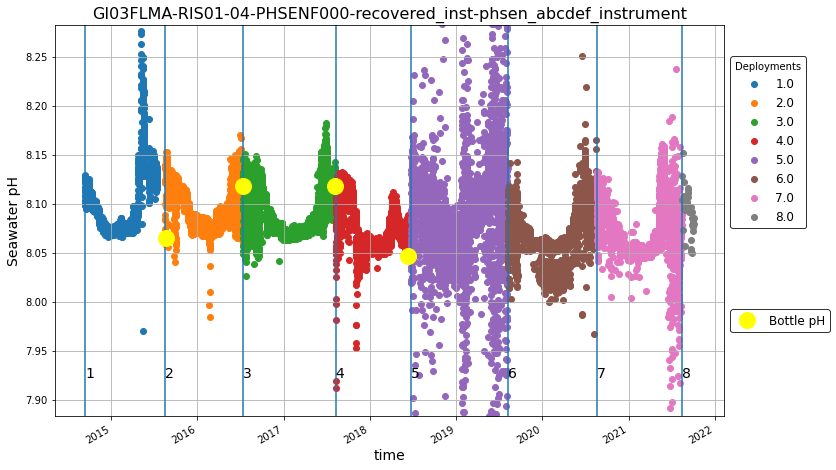

In [236]:
fig, ax = plot_variable(phsen_good, "seawater_ph")
ax.set_alpha(0.7)
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)
xmin, xmax = ax.get_xlim()

s, = ax.plot(bottles.dropna(subset=["Calculated pH"])["Start Time [UTC]"], bottles.dropna(subset=["Calculated pH"])["Calculated pH"], 
            marker="o", color="yellow", linestyle="", markersize=16, label="Bottle pH")

ax.legend(handles=[s], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)
ax.set_xlim(xmin, xmax)

In [237]:
# From the above figure, we can zoom in on deployment #3

In [238]:
phsen_dep3 = phsen_good.where(phsen.deployment == 3, drop=True)
phsen_dep3

<xarray.Dataset>
Dimensions:                            (time: 4742, blanks: 4, phsen_abcdef_signal_intensity_434_dim_0: 23, phsen_abcdef_signal_intensity_578_dim_0: 23, measurements: 23)
Coordinates:
  * time                               (time) datetime64[ns] 2016-07-13 ... 2...
  * blanks                             (blanks) int32 0 1 2 3
  * measurements                       (measurements) int32 0 1 2 3 ... 20 21 22
Dimensions without coordinates: phsen_abcdef_signal_intensity_434_dim_0, phsen_abcdef_signal_intensity_578_dim_0
Data variables: (12/25)
    blank_refrnc_434                   (time, blanks) float64 dask.array<chunksize=(4742, 4), meta=np.ndarray>
    blank_refrnc_578                   (time, blanks) float64 dask.array<chunksize=(4742, 4), meta=np.ndarray>
    blank_signal_434                   (time, blanks) float64 dask.array<chunksize=(4742, 4), meta=np.ndarray>
    blank_signal_578                   (time, blanks) float64 dask.array<chunksize=(4742, 4), meta=np.ndarray>
    deployment                         (time) float64 dask.array<chunksize=(4742,), meta=np.ndarray>
    passed_checksum                    (time) float32 dask.array<chunksize=(4742,), meta=np.ndarray>
    ...                                 ...
    signal_578                         (time, measurements) float64 dask.array<chunksize=(4742, 23), meta=np.ndarray>
    sio_controller_timestamp           (time) datetime64[ns] dask.array<chunksize=(4742,), meta=np.ndarray>
    thermistor_temperature             (time) float64 dask.array<chunksize=(4742,), meta=np.ndarray>
    unique_id                          (time) float32 dask.array<chunksize=(4742,), meta=np.ndarray>
    rollup_annotations_qc_results      (time) float64 dask.array<chunksize=(4742,), meta=np.ndarray>
    seawater_ph_quality_checks         (time) float64 dask.array<chunksize=(4742,), meta=np.ndarray>
Attributes: (12/70)
    node:                               RIS01
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_inst
    stream:                             phsen_abcdef_instrument
    ...                                 ...
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                59.76683
    lon:                                -39.8425
    Location_name:                      Global Irminger Sea Flanking Subsurfa...

In [262]:
# Find the nearest bottle samples to the start and end of deployment 3
dt = pd.Timedelta(days=1)
tmin = pd.to_datetime(phsen_dep3.time.min().values, utc=True) - dt
tmax = pd.to_datetime(phsen_dep3.time.max().values, utc=True) + dt

pH_data = bottles.dropna(subset=["Calculated pH"])
pH_data_dep3 = pH_data[(pH_data["Start Time [UTC]"] >= tmin) & (pH_data["Start Time [UTC]"] <= tmax)]

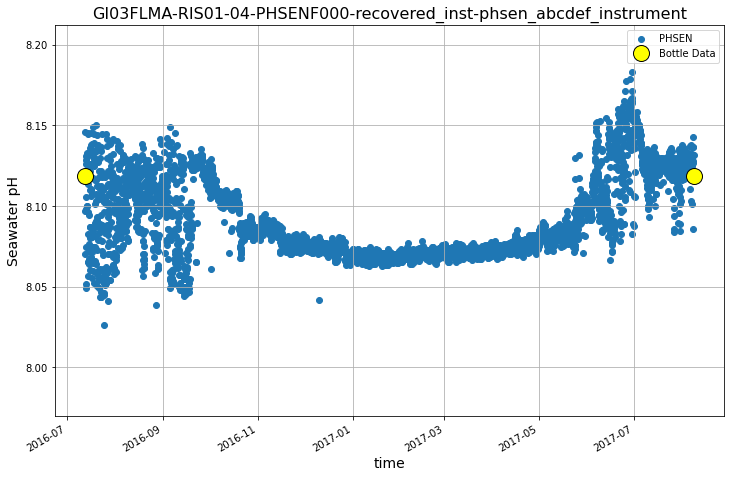

In [266]:
fig, ax = plot_variable(phsen_dep3, "seawater_ph", add_deployments=False)
ax.set_alpha(0.7)

# Plot the bottle data
ax.plot(pH_data_dep3["Start Time [UTC]"], pH_data_dep3["Calculated pH"], 
        marker="o", linestyle="", color="yellow", markersize=16, markeredgecolor="black")
ax.legend(["PHSEN", "Bottle Data"])


In [275]:
pH_data_dep3["Start Time [UTC]"] = pH_data_dep3["Start Time [UTC]"].apply(lambda x: x.tz_localize(None))

In [301]:
# Get the data to directly compare values
# Find data which is +/- 12-hours of each bottle to normalize over a daily-cycle
dt = pd.Timedelta(hours=12)
results = pd.DataFrame(columns=["Time", "Avg", "Std"])
for t in pH_data_dep3["Start Time [UTC]"]:
    mask = phsen_dep3.time[(phsen_dep3.time <= t + dt) & (phsen_dep3.time >= t-dt)]
    pH_phsen_avg = phsen_dep3["seawater_ph"][(phsen_dep3["time"] >= t-dt) & (phsen_dep3["time"] <= t + dt)].mean().values
    pH_phsen_std = phsen_dep3["seawater_ph"][(phsen_dep3["time"] >= t-dt) & (phsen_dep3["time"] <= t + dt)].std().values
    results = results.append({
        "Time": t,
        "Avg": pH_phsen_avg,
        "Std": pH_phsen_std
    }, ignore_index=True)

In [302]:
results

,Time,Avg,Std
0,2016-07-12 19:23:48,8.114428421310798,0.027203194122199684
1,2017-08-08 15:55:08,8.122179141670516,0.016993409482789476


In [286]:
# Can now compare the individual bottle values against the PHSEN-derived values

<xarray.DataArray 'time' (time: 5)>
array(['2016-07-13T00:00:00.000000000', '2016-07-13T00:00:01.000000000',
       '2016-07-13T01:59:59.000000000', '2016-07-13T03:59:59.000000000',
       '2016-07-13T05:59:59.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-07-13 ... 2016-07-13T05:59:59